# I - Notebook : Introduction & Contexte
## 1.1 - Option Pricing with Black–Scholes & Monte Carlo
Ce premier notebook introduit le projet, son objectif général et le cadre des hypothèses utilisées.

## 1.2 - Objectif du projet
Le but de ce projet est de comparer deux approches de valorisation d’options européennes :
- Analytique : la formule fermée de Black–Scholes.  
- Numérique : la simulation Monte Carlo sous mouvement brownien géométrique (GBM).
L’objectif est de vérifier la convergence des prix simulés vers les prix théoriques et de visualiser la sensibilité du prix aux paramètres (Greeks : Delta, Vega, Theta).

## 1.3 - Problématique
Comment vérifier, à l’aide de simulations, que la méthode de Monte Carlo reproduit les résultats théoriques du modèle de Black–Scholes ?
Quels enseignements peut-on tirer sur la sensibilité du prix d’une option aux paramètres clés ?

## 1.4 - Variables et notations
| Symbole | Description | Unité / Type |
|----------|--------------|---------------|
| \( S_t \) | Prix du sous-jacent au temps *t* | Monétaire |
| \( K \) | Prix d’exercice (strike) | Monétaire |
| \( r \) | Taux d’intérêt sans risque | Décimal (ex : 0.05) |
| \( \sigma \) | Volatilité du sous-jacent | Décimal annuel |
| \( T \) | Maturité (temps jusqu’à l’échéance) | Années |
| \( C, P \) | Prix du call et du put européens | Monétaire |

## 1.5 - Variables et notations

| Symbole | Description | Unité / Type |
|----------|--------------|---------------|
| \( S_t \) | Prix du sous-jacent au temps *t* | Monétaire |
| \( K \) | Prix d’exercice (strike) | Monétaire |
| \( r \) | Taux d’intérêt sans risque | Décimal (ex : 0.05) |
| \( \sigma \) | Volatilité du sous-jacent | Décimal annuel |
| \( T \) | Maturité (temps jusqu’à l’échéance) | Années |
| \( C, P \) | Prix du call et du put européens | Monétaire |



## 1.6 - Préambule projet (Windows uniquement) 

**Explication :**
1) Définit des variables d’env (PROJECT_NAME, PROJECT_ROOT, SEED) et fixe le générateur aléatoire NumPy avec np.random.seed(42) pour la reproductibilité.
2) Monkey-patch de plt.savefig → lève une RuntimeError pour empêcher toute écriture disque (zéro figures/, zéro side-effect).
3) Affiche le PROJECT_ROOT, l’état de .venv, le chemin de l’exécutable Python et VIRTUAL_ENV pour tracer l’environnement.


**Pourquoi nous avons fait cela :** 
1) Le repérage de la racine + seed globale garantit que les notebooks s’exécutent de la même façon quel que soit l’endroit d’où on les lance.
2) Les print (exécutable, VIRTUAL_ENV, cwd) donnent un feedback instantané pour diagnostiquer un mauvais kernel ou une venv non activée.
3) Le find_project_root rend les notebooks robustes aux changements de répertoire ou d’outil (VS Code, Jupyter Lab, terminal), sans chemins codés en dur.

In [52]:
import os, sys, subprocess
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 1) Trouver la racine projet (celle qui contient "rapport" et "notebook")
def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    markers = {"rapport", "notebook"}
    for _ in range(6):
        try:
            if markers.issubset({p.name for p in cur.iterdir() if p.is_dir()}):
                return cur
        except PermissionError:
            pass
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.parent

PROJECT_ROOT = find_project_root(Path.cwd())

# 2) (Optionnel) Créer .venv si absent, mais rien d'autre
VENV_DIR = PROJECT_ROOT / ".venv"
if not VENV_DIR.exists():
    print(f"🚀 Création de .venv dans : {VENV_DIR}")
    subprocess.run([sys.executable, "-m", "venv", str(VENV_DIR)], check=True)
    print("✅ .venv créé.")
else:
    print("ℹ️  .venv déjà présent.")

# 3) Variables d'env (aucun FIG_DIR)
os.environ["PROJECT_NAME"] = "OptionPricing_BS_MC"
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)
SEED = 42
np.random.seed(SEED)
os.environ["SEED"] = str(SEED)

# 4) BLOQUER toute sauvegarde de figures
_original_savefig = plt.savefig
def _blocked_savefig(*args, **kwargs):
    raise RuntimeError("Saving figures is disabled in this project (no 'figures' folder allowed).")
plt.savefig = _blocked_savefig

# 5) SUPPRIMER d'éventuels dossiers 'figures' vides (créés précédemment)
def try_remove_empty(p: Path):
    if p.exists() and p.is_dir():
        try:
            next(p.iterdir())  # s'il y a un élément, StopIteration ne tombe pas
            # non vide → on n'efface pas automatiquement
            print(f"⚠️  Dossier non vide, non supprimé : {p}")
        except StopIteration:
            p.rmdir()
            print(f"🧹 Dossier supprimé (vide) : {p}")

# chemins typiques où tu l'avais
try_remove_empty(PROJECT_ROOT / "figures")
try_remove_empty(PROJECT_ROOT / "notebook" / "figures")

print("✅ Préambule anti-figures prêt")
print(f"PROJECT_ROOT = {PROJECT_ROOT}")
print(f".venv        = {'existe' if VENV_DIR.exists() else 'absent'}")

# ==============================================================
# 💬 Activation manuelle de la venv — Windows uniquement (commentaire)
# • PowerShell :  .\.venv\Scripts\Activate.ps1
# • CMD        :  .\.venv\Scripts\activate.bat
# Exemples :
# PowerShell>  .\.venv\Scripts\Activate.ps1
# PowerShell>  .\.venv\Scripts\python.exe -m pip install ipykernel
# PowerShell>  .\.venv\Scripts\python.exe -m ipykernel install --user --name bs-mc-venv --display-name "Python (.venv) – BS/MC"
# ==============================================================
# Test de l'activation de la .venv
print(f"Python exe : {sys.executable}")
print(f"Environment : {os.environ.get('VIRTUAL_ENV', '(none)')}")
print(f"Current dir : {Path.cwd()}")





ℹ️  .venv déjà présent.
✅ Préambule anti-figures prêt
PROJECT_ROOT = C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\2 - PROJET PRICING
.venv        = existe
Python exe : C:\Users\antoi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe
Environment : (none)
Current dir : c:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\2 - PROJET PRICING\notebook


## 1.7 - Figure 1 – Schéma général du projet : du modèle GBM aux méthodes de pricing Black–Scholes et Monte Carlo

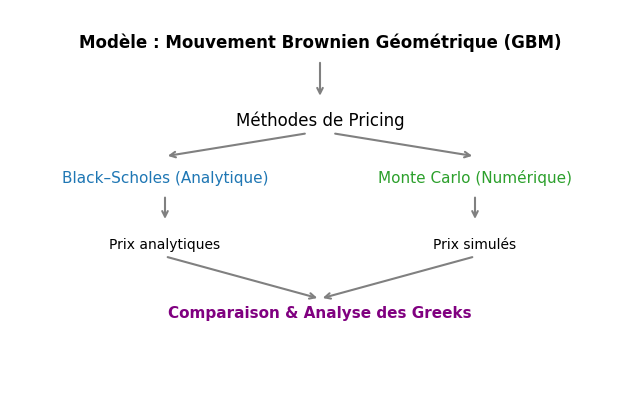

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
ax.axis("off")

# Textes
ax.text(0.5, 0.9, "Modèle : Mouvement Brownien Géométrique (GBM)", ha='center', fontsize=12, weight='bold')

ax.text(0.5, 0.7, "Méthodes de Pricing", ha='center', fontsize=12)
ax.text(0.25, 0.55, "Black–Scholes (Analytique)", ha='center', fontsize=11, color='tab:blue')
ax.text(0.75, 0.55, "Monte Carlo (Numérique)", ha='center', fontsize=11, color='tab:green')

ax.text(0.25, 0.38, "Prix analytiques", ha='center', fontsize=10)
ax.text(0.75, 0.38, "Prix simulés", ha='center', fontsize=10)

ax.text(0.5, 0.2, "Comparaison & Analyse des Greeks", ha='center', fontsize=11, weight='bold', color='purple')

# Flèches
arrowprops = dict(arrowstyle="->", color='gray', lw=1.5)
ax.annotate("", xy=(0.5, 0.77), xytext=(0.5, 0.87), arrowprops=arrowprops)
ax.annotate("", xy=(0.25, 0.62), xytext=(0.48, 0.68), arrowprops=arrowprops)
ax.annotate("", xy=(0.75, 0.62), xytext=(0.52, 0.68), arrowprops=arrowprops)
ax.annotate("", xy=(0.25, 0.45), xytext=(0.25, 0.52), arrowprops=arrowprops)
ax.annotate("", xy=(0.75, 0.45), xytext=(0.75, 0.52), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.25), xytext=(0.25, 0.36), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.25), xytext=(0.75, 0.36), arrowprops=arrowprops)

plt.show()
